# DATA ANALYSIS - SIGNIFICANT EARTHQUAKES, 1965-2016

In [130]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import geopandas as gpd

## I. Questions to ask

I live in Tokyo. Recently there are not much earthquakes around here, and to be honest I quite miss that thrilling experience of feeling the vibrant through my body. Coincidentally, I am taking Udacity Nanodegree - Data Scientists. Thus, I would like to have a dive into earthquake data, with these 3 questions:

1. Which places are most vulnerable to earthquakes and seismic activities around the world, and in Japan?
2. What are the nature characteristics of heavy earthquakes? Which factors determine a strong earthquake?
3. Sometimes a seismic activity is caused by nuclear explosion. How can we detect a nuclear explosion based on seismic data solely?

## II. Data Preparation

This dataset includes a record of the date, time, location, depth, magnitude, and source of every earthquake with a reported magnitude 5.5 or higher across the world, from 1965 to 2016.

The dataset is collected by The National Earthquake Information Center (NEIC), serving as a foundation for scientific research through the operation of modern digital national and global seismograph networks and cooperative international agreements.

The dataset can be found on [Kaggle dataset site](https://www.kaggle.com/datasets/usgs/earthquake-database/data?select=database.csv).

In [105]:
# Load dataset
read_df = pd.read_csv("./data/database.csv")
read_df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


### 1. Select columns for analysis

In [106]:
# Data schema information
print(f"Dataset size: {read_df.shape[0]} rows x {read_df.shape[1]} columns.")
print(f"Dataset overview:")
read_df.info()

Dataset size: 23412 rows x 21 columns.
Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               729

As we can see, there are only a handful of columns in the dataset that are sufficient and useful for actual analysis. They are `Date`, `Time`, `Latitude`, `Longitude`, `Type`, `Depth`, `Magnitude`, and `Magnitude Type`. The last 5 columns, although they are sufficient, the data is only about metadata itself, having no values on analysis.

So, we select the 8 columns above.

In [107]:
# Select the 8 columns
datetime_cols = ["Date", "Time"]
geo_cols = ["Latitude", "Longitude"]
anal_cols = ["Type", "Depth", "Magnitude"]
anal_df = read_df[datetime_cols + geo_cols + anal_cols]
anal_df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,6.0
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,5.8
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,5.8


### 2. Cleaning and transforming

#### a. NaN handling

In [108]:
# Check for NaN
print(anal_df.isna().sum())

Date         0
Time         0
Latitude     0
Longitude    0
Type         0
Depth        0
Magnitude    0
dtype: int64


Only 3 NaNs in the `Magnitude Type` column among 23,412 data points, so it's definitely safe to just trim them out.

In [109]:
# Drop NaNs. NaN is good only in India.
anal_df = anal_df.dropna()
print(anal_df.isna().sum())
print(f"Dataset size: {anal_df.shape[0]} rows x {anal_df.shape[1]} columns.")

Date         0
Time         0
Latitude     0
Longitude    0
Type         0
Depth        0
Magnitude    0
dtype: int64
Dataset size: 23412 rows x 7 columns.


#### b. TimeSeries data handling

Basically just converting date and time data into Datetime data type, with formats of `yyyy-mm-dd` and `hh:mm:ss`.

In [110]:
# Convert "Date" and "Time" column into timeseries data
anal_df["Date"] = pd.to_datetime(
    anal_df["Date"],
    yearfirst = True,
    utc = True
).dt.date
anal_df["Time"] = pd.to_datetime(
    anal_df["Time"],
    utc = True
).dt.time
anal_df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude
0,1965-01-02,13:44:18,19.246,145.616,Earthquake,131.6,6.0
1,1965-01-04,11:29:49,1.863,127.352,Earthquake,80.0,5.8
2,1965-01-05,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2
3,1965-01-08,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8
4,1965-01-09,13:32:50,11.938,126.427,Earthquake,15.0,5.8


## IV. Data analysis

### 1. Data distribution

array([[<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>],
       [<AxesSubplot:title={'center':'Depth'}>,
        <AxesSubplot:title={'center':'Magnitude'}>]], dtype=object)

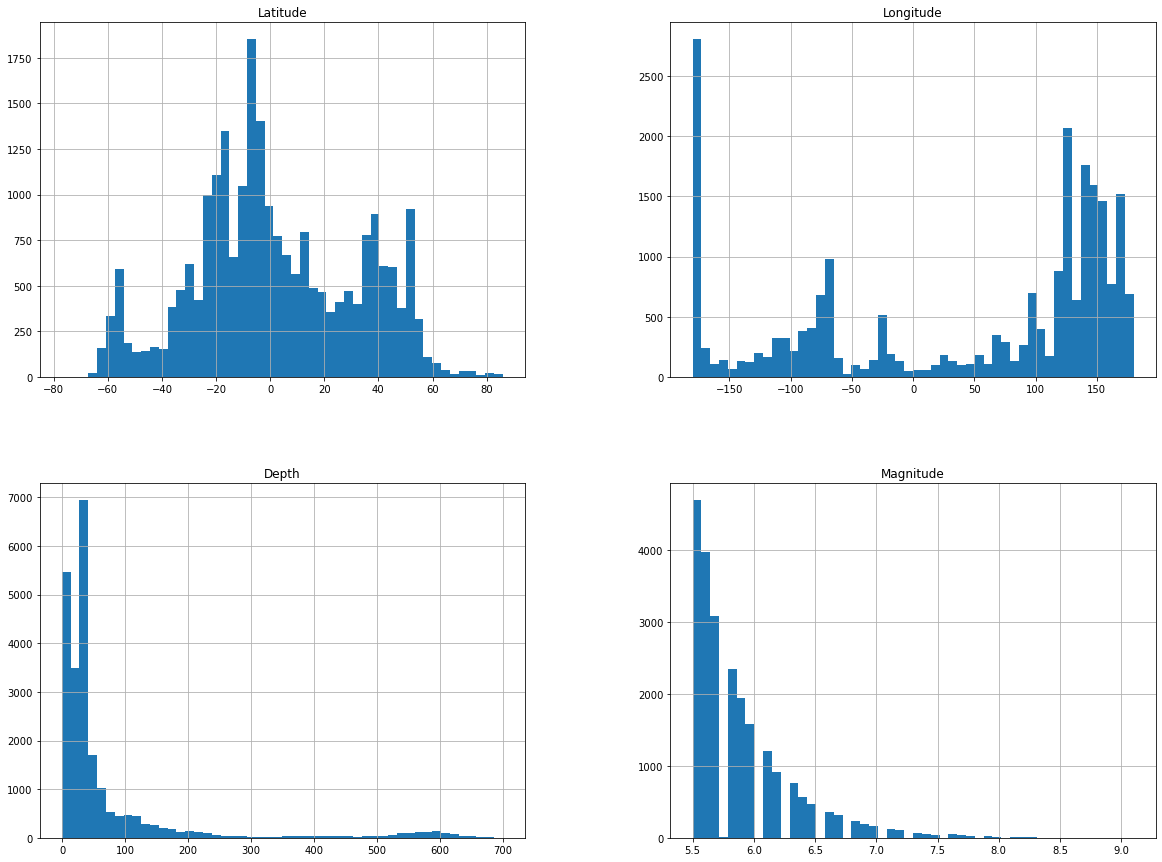

In [111]:
# Histogram
anal_df[geo_cols + anal_cols].hist(
    figsize = [20, 15], 
    bins = 50
)

In [112]:
# Gather some insights about lat/long/depth distributions
perc_lat_tropical = ((anal_df["Latitude"] < 23.5) & (anal_df["Latitude"] > -23.5)).sum() / anal_df.shape[0] * 100
perc_long_high = (abs(anal_df["Longitude"]) > 150).sum() / anal_df.shape[0] * 100
perc_low_depth = (anal_df["Depth"] < 100).sum() / anal_df.shape[0] * 100

print(f"Earthquakes happen within tropical zone (23.5 North to 23.5 South) : {perc_lat_tropical:.2f}%")
print(f"Earthquakes happen at high longitudes (higher than 150 deg) : {perc_long_high:.2f}%")
print(f"Earthquakes happen at shallow depths (less than 100 m) : {perc_low_depth:.2f}%")

Earthquakes happen within tropical zone (23.5 North to 23.5 South) : 55.71%
Earthquakes happen at high longitudes (higher than 150 deg) : 34.12%
Earthquakes happen at shallow depths (less than 100 m) : 84.06%


In [113]:
# Categorize magnitudes based on Richter scale
categories = [
    "Moderate magnitude",
    "Strong magnitude",
    "Major magnitude",
    "Great magnitude"
]
ranges = [5.0, 6.0, 7.0, 8.0, 10.0]

anal_df["Magnitude category"] = pd.cut(
    anal_df["Magnitude"],
    bins = ranges,
    labels = categories,
    right = False
)

perc_magCats = (anal_df["Magnitude category"].value_counts() / anal_df.shape[0] * 100).round(2)

print("Percentages of 4 magnitude categories: ")
print(perc_magCats)

Percentages of 4 magnitude categories: 
Moderate magnitude    68.59
Strong magnitude      28.26
Major magnitude        2.98
Great magnitude        0.17
Name: Magnitude category, dtype: float64


As we can see from the histogram of those 4 numerical columns:

#### a. Latitude

Regarding latitude, it seems earthquake primarily occurs around the equator where latitude = 0. Based on the data, over half (55.72%) of earthquakes occurred within tropical zone.

#### b. Longitude

In contrast to latitude, looks like the majority of earthquakes happen at high longitudes. Based on the data, over one-third (34.12%) of earthquakes occurred at high altitudes.

Further investigation about locations should be done later in first question.

#### c. Depth

A majority of the earthquakes occurred at shallow depths. Based on the data, an overwhelming amounts of earthquakes (84.06%) occurred no deeper than 100 meters.

However, there is also a portion of earthquakes that occur around 600 meters depth as well.

#### d. Magnitude

Thankfully, based on the data, a majority of the earthquakes, almost 70%, are moderate ones - causing damage of varying severity to poorly constructed buildings. Almost 30% are strong ones, which can tear down buildings with no earthquake-resistant structures. Only around 3% of earthquakes are truly nightmarish, wreaking true havocs and claming massive amounts of lives.

### 2. First question: Earthquake geographical distribution

#### a. Worldwide

In [131]:
# ---- Function to plot geographical data with real-world map ---- #
def plotGeoLatLongData(
    df, worldMap, 
    xlabel, ylabel, title, fontsize, 
    categorize = None, 
    byMagnitude = None
):
"""
Generate a geographical figure that visualizes earthquake data, including location data,
as well as other information, on a real-life map.
----------
Parameters
----------
    df : [pandas.DataFrame]
        dataframe containing geographical data. It must contain a column "Latitude" and
        a column "Longitude" containing lat/long data respectively.
    worldMap : [geopandas.GeoDataFrame]
        geopandas dataframe containing real-life map, which will be used as background
        for the geographical data plot.
    xlabel, ylabel, title : [string]
        x-axis label, y-axis label, and title of the plot.
    fontsize : [integer]
        font size of the above 3 text elements of the plot.
    categorize : [string, default None]
        if specified, plot's marker color will be determined by the column with that name.
    byMagnitude : [object, default None]
        if specified, plot's marker size will be determined by the earthquake's magnitude.
-------
Returns
-------
    A seaborn scatterplot with earthquake data and real-life map as background.
"""
    if byMagnitude:
        byMagnitude = df["Magnitude"]
    if categorize:
        categorize = df[categorize]
    sns.scatterplot(
        ax = worldMap.plot(figsize = [15, 15]),
        x = df["Longitude"],
        y = df["Latitude"],
        color = "red",
        hue = categorize,
        size = byMagnitude,
        sizes = (20, 200)
    )
    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    plt.title(title, fontsize = fontsize)
    plt.legend(loc = "upper left")
    plt.show()

/var/folders/bl/1djvl9ms7tz1v4t6_xz0tc_h0000gn/T/ipykernel_84485/885417415.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


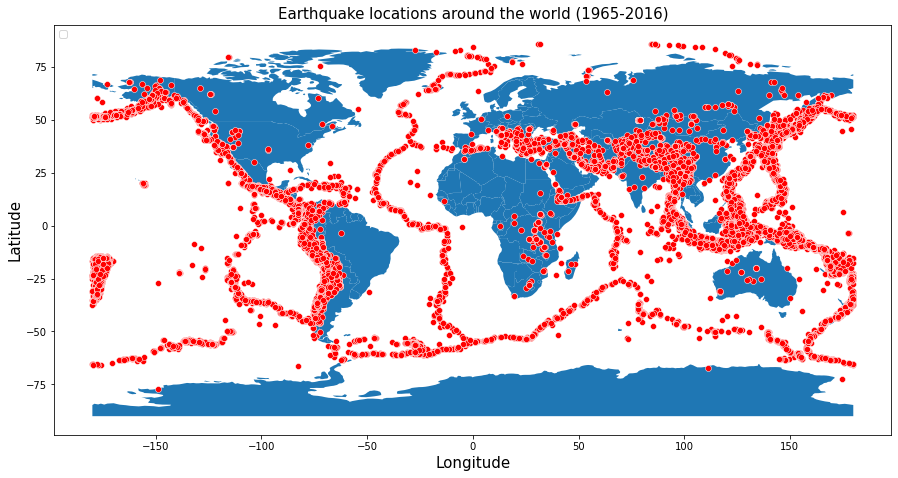

In [115]:
# Generate world map
worldMap = gpd.read_file(
    gpd.datasets.get_path("naturalearth_lowres")
)

# Plot global earthquake locations
plotGeoLatLongData(
    anal_df, worldMap,
    xlabel = "Longitude",
    ylabel = "Latitude",
    title = "Earthquake locations around the world (1965-2016)",
    fontsize = 15
)

We can clearly see that, a staggering majority of earthquakes occur along the Earth's major tectonic plate boundaries, which is absolutely true for our consensus about earthquakes. 

We can also see that a lot of earthquakes happen along the region of Indonesia, and East Australia. This is because these regions are on the boundaries of 3 tectonic plates: Indian-Australian, Earasian, and Pacific. The latitudes and longitudes of these regions also help us explain why there are a lot of earthquakes in tropical zones, and in high longitudes.

The image below shows real Earth's tectonic plate boundaries, from which we can see striking resemblances of our map above.

![Tecnotic plate boundaries](./assets/Tectonic_plates_(2022).png)

#### b. Japan

In [116]:
# Extract earthquake data that only occurs around Japan
japan_df = anal_df.loc[
    (anal_df["Latitude"] > 30) & (anal_df["Latitude"] < 46) &
    (anal_df["Longitude"] > 128) & (anal_df["Longitude"] < 146)
]

print(f"Number of earthquakes in Japan from 1965 to 2016: {japan_df.shape[0]}\n")

perc_magCats_Japan = (japan_df["Magnitude category"].value_counts() / japan_df.shape[0] * 100).round(2)

print("Percentages of 4 magnitude categories in Japan: ")
print(perc_magCats_Japan)

Number of earthquakes in Japan from 1965 to 2016: 1356

Percentages of 4 magnitude categories in Japan: 
Moderate magnitude    65.93
Strong magnitude      30.83
Major magnitude        3.02
Great magnitude        0.22
Name: Magnitude category, dtype: float64


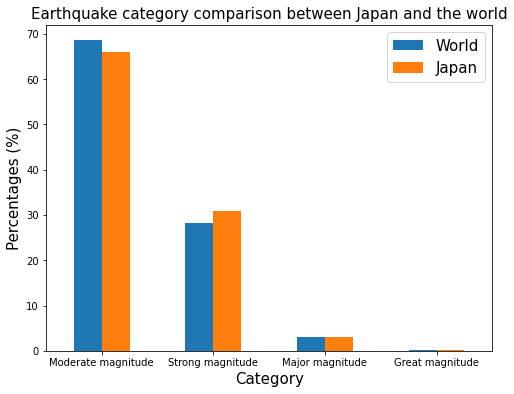

In [117]:
# Comparison between global and Japan data
cat_worldVsJapan = pd.DataFrame({
    'Category' : categories,
    'World' : perc_magCats.values,
    'Japan' : perc_magCats_Japan.values
})
cat_worldVsJapan.set_index(
    'Category',
    inplace = True
)

# Plot the comparison
ax = cat_worldVsJapan.plot(
    kind = 'bar', 
    figsize = (8, 6)
)
plt.xlabel('Category', fontsize = 15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.ylabel('Percentages (%)', fontsize = 15)
plt.title('Earthquake category comparison between Japan and the world', fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 15)

From the figure, we can see that Japan generally has stronger earthquakes with greater magnitudes compared to the rest of the world. This is why Japan is famous for both being constantly ravaged by earthquakes, and at the same time its seismic-proof architecture, a testament of its people's diligence.

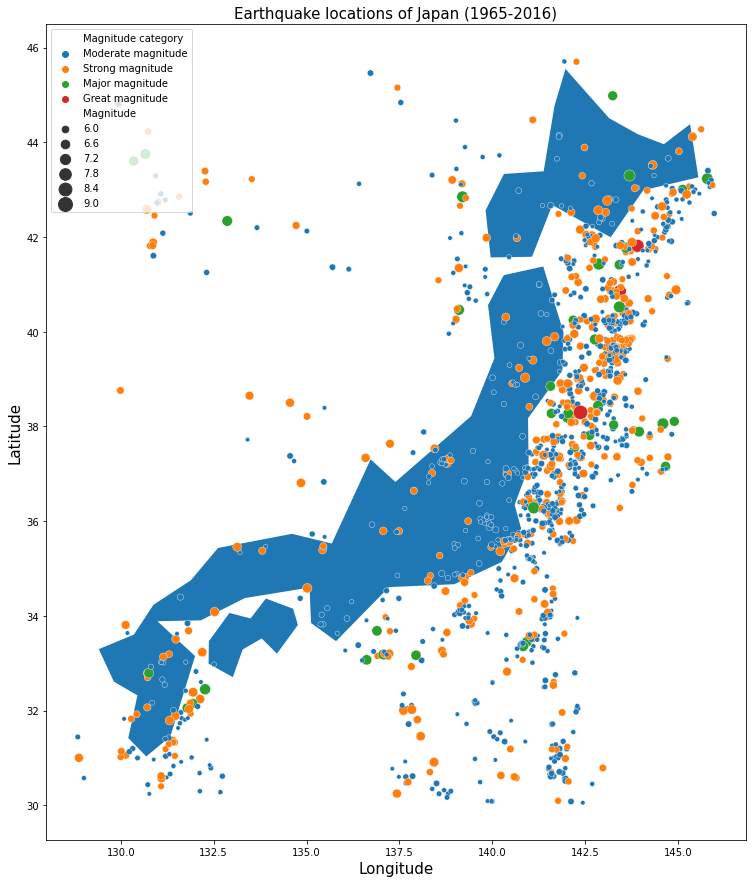

In [118]:
# Generate Japan map
japanMap = worldMap[worldMap["name"] == "Japan"]

# Plot global earthquake locations
plotGeoLatLongData(
    japan_df, japanMap,
    xlabel = "Longitude",
    ylabel = "Latitude",
    title = "Earthquake locations of Japan (1965-2016)",
    fontsize = 15,
    categorize = "Magnitude category",
    byMagnitude = True
)

We can see that in general earthquakes in Japan occur along the Eastern coast, which is kinda self-explanatory since the tectonic plate boundary is there. A staggering amount of earthquakes are around the Tohoku sea, and also within the region, we can see 3 great earthquakes there as well, with the biggest one being the infamous [2011 Great Tohoku Earthquake and Tsunami](https://en.wikipedia.org/wiki/2011_T%C5%8Dhoku_earthquake_and_tsunami).

In [119]:
# Examine those 3 great earthquakes in Japan
japan_great_df = japan_df[japan_df["Magnitude category"] == "Great magnitude"]
japan_great_df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude category
911,1968-05-16,00:49:02,40.860,143.435,Earthquake,29.9,8.2,Great magnitude
16446,2003-09-25,19:50:06,41.815,143.910,Earthquake,27.0,8.3,Great magnitude
20501,2011-03-11,05:46:24,38.297,142.373,Earthquake,29.0,9.1,Great magnitude


So, moral of the story? Don't settle near Tohoku coastlines lol.

(But not gonna lie, those places are gorgeous. I went there during the 2022 Tohoku Double Seventh Festival, one of the best trips of my life probably).

### 3. Second question: Factors determining a strong earthquake

To deal with this question, we first try to see how those numerical columns correlate with the earthquake magnitude.

To provide more insights into the temporal aspects of these events, these columns are added:
- `Day of week` : day in week, starting by 0 on Monday and ending by 6 on Sunday.
- `Day` : basically the `dd` part in `yyyy-mm-dd`.
- `Month` : basically the `mm` part in `yyyy-mm-dd`.
- `Year` : basically the `yyyy` part in `yyyy-mm-dd`.
- `Week of year` : week in a year, in the range of 0 - 53.

In [120]:
# Additional temporal columns
anal_df["Day of week"] = pd.to_datetime(
    anal_df["Date"],
    utc = True
).dt.dayofweek
anal_df["Day"] = pd.to_numeric(anal_df["Date"].astype(str).str[8:])
anal_df["Month"] = pd.to_numeric(anal_df["Date"].astype(str).str[5:7])
anal_df["Year"] = pd.to_numeric(anal_df["Date"].astype(str).str[:4])
anal_df["Week of year"] = pd.to_datetime(
    anal_df["Date"],
    utc = True
).dt.isocalendar().week
temporal_cols = [
    "Day of week",
    "Day",
    "Month",
    "Year",
    "Week of year"
]

# Besides earthquakes, there are also seismic data caused by nuclear explosion events.
# Thus, we select only earthquakes.
earthquake_df = anal_df[anal_df["Type"] == "Earthquake"]
print(f"Number of earthquakes / Total seismic activities : {earthquake_df.shape[0]} / {anal_df.shape[0]}")
earthquake_df.head()

Number of earthquakes / Total seismic activities : 23232 / 23412


,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude category,Day of week,Day,Month,Year,Week of year
0,1965-01-02,13:44:18,19.246,145.616,Earthquake,131.6,6.0,Strong magnitude,5,2,1,1965,53
1,1965-01-04,11:29:49,1.863,127.352,Earthquake,80.0,5.8,Moderate magnitude,0,4,1,1965,1
2,1965-01-05,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,Strong magnitude,1,5,1,1965,1
3,1965-01-08,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,Moderate magnitude,4,8,1,1965,1
4,1965-01-09,13:32:50,11.938,126.427,Earthquake,15.0,5.8,Moderate magnitude,5,9,1,1965,1


array([[<AxesSubplot:title={'center':'Day of week'}>,
        <AxesSubplot:title={'center':'Day'}>],
       [<AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Year'}>],
       [<AxesSubplot:title={'center':'Week of year'}>, <AxesSubplot:>]],
      dtype=object)

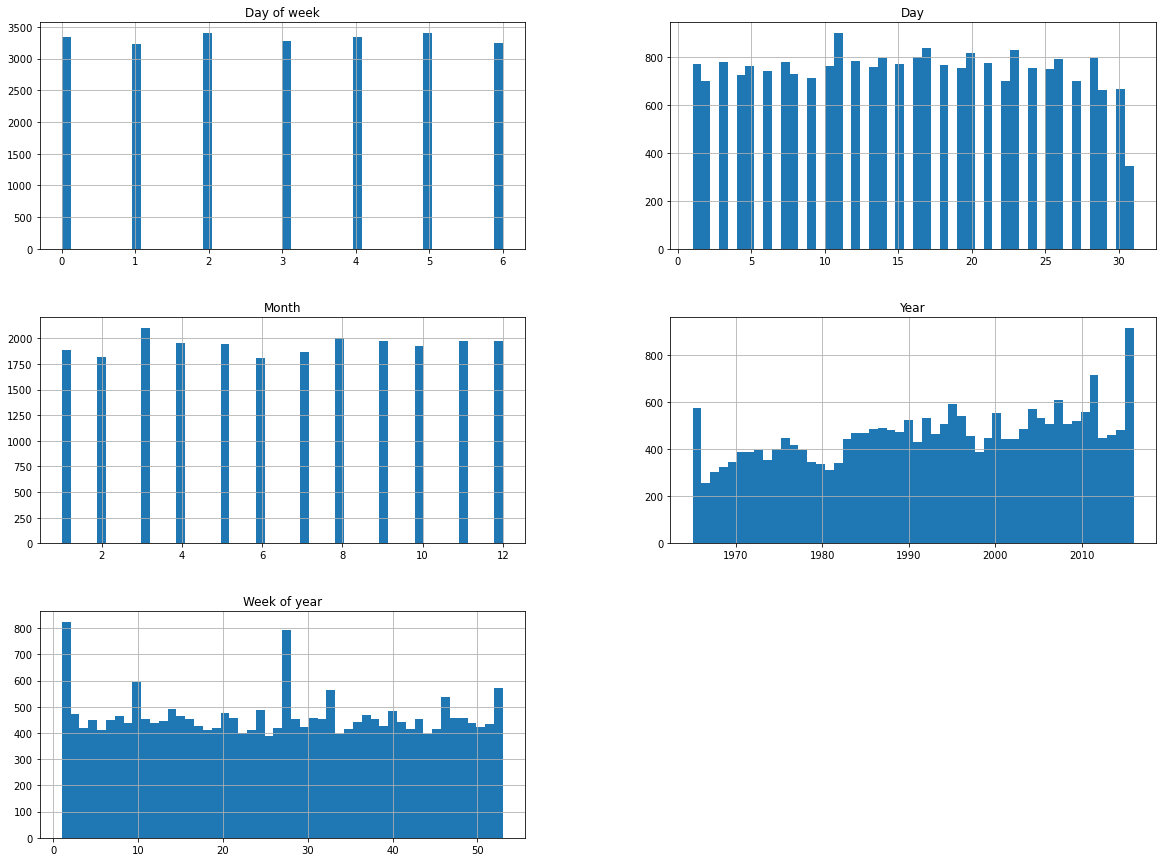

In [121]:
# Histogram
earthquake_df[temporal_cols].hist(
    figsize = [20, 15], 
    bins = 50
)

Practically speaking, the earthquakes distribute evenly through days in a month, months, and weekdays. However, looking at the `Week of year` we can see that there are 2 annual periods that earthquakes tend to happen more than the rest of the year, which is the beginning of the year (R.I.P New Year's Eve enjoyers), and in the middle of the year. I tried to find an explanation for this, but to no avail.

Also, there seems to be an increase in earthquake records gradually.

Text(0.5, 1.0, 'Correlation of numerical features')

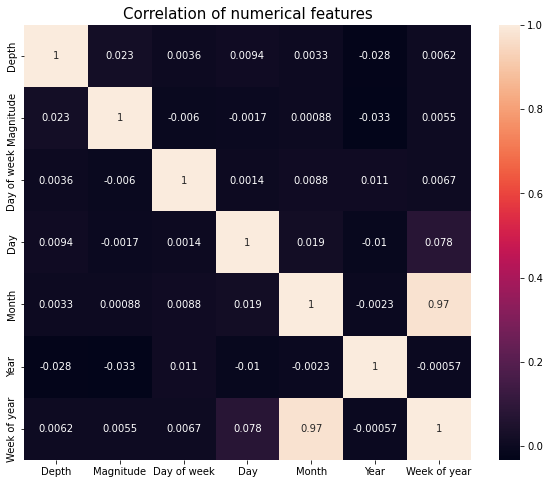

In [122]:
# Correlation heatmap
earthquake_corr = earthquake_df[anal_cols + temporal_cols].corr()
plt.figure(figsize = (10, 8))
sns.heatmap(
    earthquake_corr,
    annot = True,
)
plt.title("Correlation of numerical features", fontsize = 15)

We can clearly see that there is literally no correlations between the numerical features of this earthquake dataset. The only good correlation of 0.97 is between `Month` and `Week of year`, which is clearly obvious and has no data meaning.

So, does it mean the magnitude is totally random? Well, probably, but we can also look at their locations. The figure below shows locations of earthquakes greater than 6.0 (strong category and above) around Earth.

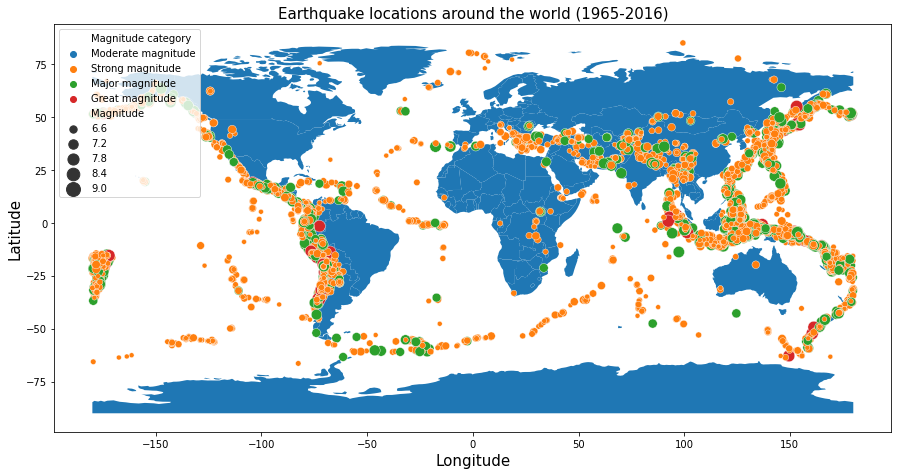

In [123]:
# Plot global earthquake locations with magnitude of 6.0 and greater
plotGeoLatLongData(
    earthquake_df[earthquake_df["Magnitude"] > 6.0],
    worldMap,
    xlabel = "Longitude",
    ylabel = "Latitude",
    title = "Earthquake locations around the world (1965-2016)",
    fontsize = 15,
    categorize = "Magnitude category",
    byMagnitude = True
)

From the map above, we can see that, although the strong ones (6.0 - 7.0 magnitude) still scatter around the boundaries, the major ones tend to occur around:
- The Western coast of America continent, where a lot of tectonic plates (North America, Caribbean, Cocos, Nazca, Juan de Fuca, Pacific, and South America plates) interact with each other.
- The Arabian & Middle East region, along the intersections of Eurasian, African, Arabian and Indian plates.
- The Indonesia region, intersection of two huge tectonic plates of Eurasian and Australian.
- The Eastern Australia, intersection of another two huge tectonic plates of Australian and Pacific.
- The Japan region, as we know it.

So, we can have a consensus that earthquake magnitude, although seems to be random, indeed correlates with locations, especially those with high tectonic intensity due to being intersections of multiple, or major tectonic plates.

As the knowledge of tectonic plate boundaries and their correlation with earthquakes are widely known, I decided that the modeling part is not needed in this project.

### 4. Last question: How to detect a nuclear explosion from its seismic activity?

For this, first we can extract the little portion of nuclear explosion dataset, and then examine the data to see if there are any interesting insights.

In [124]:
# Select nuclear explosion events.
nuke_df = anal_df[anal_df["Type"] == "Nuclear Explosion"]
print(f"Number of nukes / Total seismic activities : {nuke_df.shape[0]} / {anal_df.shape[0]}")
nuke_df.head()

Number of nukes / Total seismic activities : 175 / 23412


,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude category,Day of week,Day,Month,Year,Week of year
565,1966-12-20,15:30:01,37.302167,-116.408333,Nuclear Explosion,1.2,5.62,Moderate magnitude,1,20,12,1966,51
897,1968-04-26,15:00:02,37.295333,-116.455667,Nuclear Explosion,1.2,5.63,Moderate magnitude,4,26,4,1968,17
1129,1968-12-19,16:30:01,37.231500,-116.473667,Nuclear Explosion,1.4,5.52,Moderate magnitude,3,19,12,1968,51
1380,1969-09-16,14:30:01,37.314167,-116.460667,Nuclear Explosion,1.2,5.82,Moderate magnitude,1,16,9,1969,38
1532,1970-03-26,19:00:01,37.300500,-116.534167,Nuclear Explosion,1.2,5.54,Moderate magnitude,3,26,3,1970,13


In [125]:
# Categorize nuclear events based on year
categories = [
    "1965-1975",
    "1975-1985",
    "1985-1995",
    "1995 and beyond"
]
ranges = [1965, 1975, 1985, 1995, 2000]

nuke_df["Year range"] = pd.cut(
    nuke_df["Year"],
    bins = ranges,
    labels = categories,
    right = False
)

perc_yearRange = nuke_df["Year range"].value_counts().sort_index()
print("Number of nuclear explosions by year ranges:")
print(perc_yearRange)

Number of nuclear explosions by year ranges:
1965-1975           17
1975-1985          106
1985-1995           49
1995 and beyond      3
Name: Year range, dtype: int64


/var/folders/bl/1djvl9ms7tz1v4t6_xz0tc_h0000gn/T/ipykernel_84485/7269125.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuke_df["Year range"] = pd.cut(


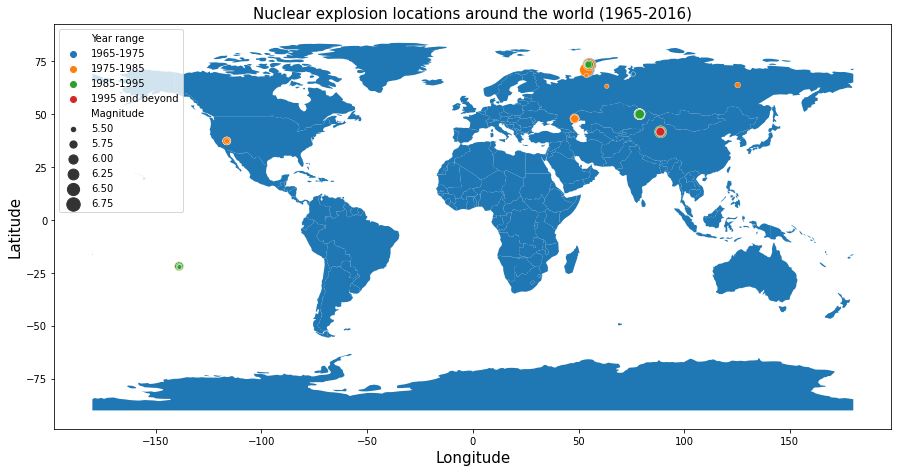

In [126]:
# Plot nuke locations
plotGeoLatLongData(
    nuke_df, worldMap,
    xlabel = "Longitude",
    ylabel = "Latitude",
    title = "Nuclear explosion locations around the world (1965-2016)",
    fontsize = 15,
    categorize = "Year range",
    byMagnitude = True
)

In [127]:
print(nuke_df[["Date", "Time", "Latitude", "Longitude", "Depth", "Magnitude"]])

             Date      Time   Latitude   Longitude  Depth  Magnitude
565    1966-12-20  15:30:01  37.302167 -116.408333    1.2       5.62
897    1968-04-26  15:00:02  37.295333 -116.455667    1.2       5.63
1129   1968-12-19  16:30:01  37.231500 -116.473667    1.4       5.52
1380   1969-09-16  14:30:01  37.314167 -116.460667    1.2       5.82
1532   1970-03-26  19:00:01  37.300500 -116.534167    1.2       5.54
...           ...       ...        ...         ...    ...        ...
11963  1994-06-10  06:25:58  41.527000   88.710000    0.0       5.80
12142  1994-10-07  03:25:58  41.662000   88.753000    0.0       6.00
12450  1995-05-15  04:05:58  41.603000   88.820000    0.0       6.10
12613  1995-08-17  00:59:58  41.559000   88.800000    0.0       6.00
13054  1996-06-08  02:55:58  41.657000   88.690000    0.0       5.90

[175 rows x 6 columns]


array([[<AxesSubplot:title={'center':'Day of week'}>,
        <AxesSubplot:title={'center':'Day'}>,
        <AxesSubplot:title={'center':'Month'}>],
       [<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Week of year'}>,
        <AxesSubplot:title={'center':'Depth'}>],
       [<AxesSubplot:title={'center':'Magnitude'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

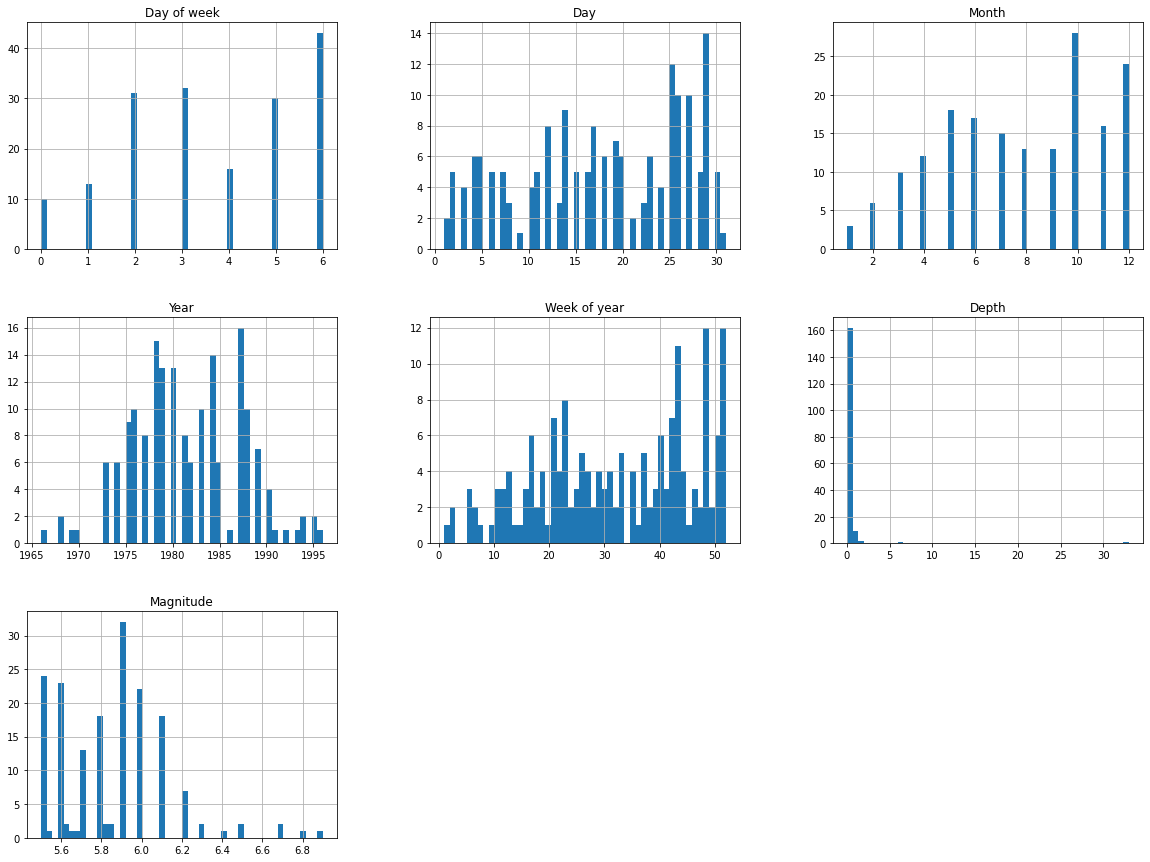

In [128]:
# Histogram
nuke_df[temporal_cols + anal_cols].hist(
    figsize = [20, 15], 
    bins = 50
)

From the data above, we can have several insights:

#### a. Location and time

- From the map above, we can see a majority of the nuclear tests came from the US and Soviet Union, and some of them came from territory of People's Republic of China, way after 1995. Before 1995, the nuclear playground is primarily occupied by the two superpowers of US and Soviet Union.

- Given that 175 recorded tests spanned from 1966 till 1996 - several years later after Soviet Union collapsed and the Cold War settled, we can clearly see that these nuke explosions are nuke tests. During the period of 1975-1985, there were an overwhelming amount of records on nuclear explosions, compared to other periods. Historically speaking, this is somewhat correlated to major geopolitics events in this period, such as the end of Vietnam War (1975), the Sino-Soviet split in Communist relations between China and Soviet Union, and so on.

- The most important finding is that, the locations of these nuclear tests are nowhere on the tectonic plate boundaries, being separated completely from the vast majority of natural earthquake events (like, seriously do you wanna test a nuclear bomb at some unstable places full of earthquakes?). This is a bright feature to determine if a seismic activity is likely a nuke test, or just a natural earthquake.

#### b. Magnitude

The magnitudes of these nuke tests are typically not quite high, usually lower than 7.0 degree, which just equivalent to strong earthquakes.

#### c. Depth

The depths of these nuke tests are typically on the ground level, or just very shallow, no deeper than 30 meters, which is quite different from those of natural earthquakes.

## V. Summary

So, to answer those original 3 questions:

#### 1. Earthquake distributions and characteristics, globally and in Japan

- Globally:
    + Occurs along tectonic plate boundaries.
    + Shallow depths, primarily no deeper than 100 meters, but sometimes might be up to 600 meters.
    + Primarily major magnitude of less than 6.0 Richter degree, or sometimes up to 7.0, which is fortunate.
- In Japan:
    + Occurs along the Tohoku sea.
    + Generally more intense than global average in terms of magnitude.
    + Greatest earthquakes in modern history occurred here.

#### 2. Factors determining earthquake intensity

- Generally, magnitude tends to be random.
- Some specific tectonic plate boundaries have higher chance to experience higher magnitudes.

#### 3. Nuclear explosions vs natural earthquakes

- Comparing to natural earthquakes, nuclear explosions:
    + Occurred during the Cold War only, although now we still have it (look at the North Korea lol) but they tend to fly the ICBMs over Japan and explode them on upper layers of the atmosphere, so no seismic records here.
    + Did not occur at natural tectonic plate boundaries, but at designated nuke test sites.
    + Low magnitudes compared to natural earthquakes.
    + Shallow depths, usually on ground level.